In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!chmod 755 -R /content/drive/MyDrive/virtual_env/bin

In [ ]:
import sys
# add the path of the virtual environmentsite-packages to colab system path
sys.path.append("/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages")

In [ ]:
from adjustText import adjust_text
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import os
import seaborn as sns
import sys
from glob import iglob
from scipy import sparse
from scipy.sparse import coo_matrix
import math

In [ ]:
# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')


scanpy==1.9.8 anndata==0.10.5.post1 umap==0.5.5 numpy==1.25.2 scipy==1.11.4 pandas==2.0.3 scikit-learn==1.2.2 statsmodels==0.14.2 igraph==0.10.8 pynndescent==0.5.11


In [ ]:
# the directory with the `.h5` file
# use gene symbols for the variable names (variables-axis index)
input_dir="/content/drive/MyDrive/LeoDai/Private_Data/GeneSet_Enrichment/rat"
output_fig_dir="/content/drive/MyDrive/LeoDai/Private_Data/GeneSet_Enrichment/rat"
output_dir="/content/drive/MyDrive/LeoDai/Private_Data/GeneSet_Enrichment/rat"
de_gene_dir="/content/drive/MyDrive/LeoDai/Private_Data/DE_genes/rat"
input_DE_dir ="/content/drive/MyDrive/LeoDai/Private_Data/DE_genes/rat"
sc.settings.figdir = output_dir

In [ ]:
#create gene set with significant GSEA results
subdir_list = ['exc_subclass']

for subdir in subdir_list:

 for file in os.listdir(os.path.join(input_dir,subdir)):
  #find GSEA output txt file
  subclass = ""
  if file.endswith("_Cov.csv"):
    subclass = file[5:file.find("_limmatrend")]
    print(subclass)
    gsea_df = pd.read_csv(os.path.join(input_dir,subdir,file),sep=",",header=0,index_col=False)
    #print(gsea_df[[1,2,3,4,5,6]])
    if "highlighted" not in gsea_df.columns :
      gsea_df = gsea_df[gsea_df['adjusted_p_value']<0.01]
    else:
      #print(gsea_df)
      gsea_df = gsea_df[gsea_df['highlighted']==True]
    print(gsea_df.shape)
    gsea_df.replace("",np.nan,inplace=True)
    gsea_df.dropna(axis="columns",how="all",inplace=True)
    gsea_df.to_csv(os.path.join(output_dir,subdir,subclass+"_gsea_sig.tsv"),sep="\t",index=False)
    genes_sel = gsea_df.columns[10:]
    pd.DataFrame({'gene':genes_sel}).to_csv(os.path.join(output_dir,subdir,subclass+"_genes_sel.tsv"),sep="\t",index=False)
    #print(genes_sel)

In [ ]:
#check if there is overlap between gene sets
subclass_genelist = dict()
#subdir_list = ['exc_subclass','inh_subclass','nn_subclass']
gene_set_total = []

#for subdir in subdir_list:
subdir = 'exc_subclass'
for file in os.listdir(os.path.join(input_dir,subdir)):
  #find GSEA gene set txt file
  subclass = ""
  if file.endswith("_genes_sel.tsv"):
    subclass = file[0:file.find("_genes_sel.tsv")]
    #print(subclass)
    gene_df = pd.read_csv(os.path.join(input_dir,subdir,file),sep=",",header=0,index_col=False)
    gene_list = gene_df['gene'].tolist()
    subclass_genelist[subclass] = gene_list
    gene_set_total.extend(gene_list)
    #print(gene_list)


uniq_genes_total = np.unique(gene_set_total)
print(len(uniq_genes_total))
ovp_genes = []

for key, value in subclass_genelist.items():
  for key2, value2 in subclass_genelist.items():
    if key != key2:
      size = min(len(value),len(value2))
      print(key + ":" + str(len(value)) + " , " + key2 + ":" + str(len(value2)) + " , " + str(len(set(value).intersection(set(value2)))) + " , " + str(len(set(value).intersection(set(value2)))/size))
      ovp = set(value).intersection(set(value2))
      ovp_genes.extend(ovp)
      #print(ovp)
      #print(len(ovp))
      #print(set(value).intersection(set(value2)))

uniq_genes_ovp = np.unique(ovp_genes)
print(len(uniq_genes_ovp))
remain_genes = list(set(uniq_genes_total).difference(set(uniq_genes_ovp)))
print(len(remain_genes))
for key, value in subclass_genelist.items():
  print(key + ":" + str(len(value)) + " , " + str(len(set(value).intersection(set(remain_genes)))))

pd.DataFrame({'gene':remain_genes}).to_csv(os.path.join(output_dir,subdir+"_genes_remove_dup.tsv"),sep="\t",index=False)

In [ ]:
#select top 5 genes from the DE analysis for each cell type
input_DE_dir ="/content/drive/MyDrive/LeoDai/Private_Data/DE_genes/rat"

In [ ]:
subdir = "exc_subclass"
celldir = "exc_celltype"

DE_genes = dict()
celltype_list = []

for file in os.listdir(os.path.join(input_DE_dir,subdir)):
  if file.endswith("_Cov.tsv") :
    celltype = file[0:file.find("_limmatrend")]
    #print(celltype)
    celltype_list.append(celltype)
    DE_genes[celltype] = []

In [ ]:
celltype = file[0:file.find("_limmatrend")]
celltype_list.append(celltype)
for file in os.listdir(os.path.join(input_DE_dir,subdir,"run2","sigDE","adjPval05FC1.4")):
  #find cell type top DE gene output txt file
  if file.endswith("top_gene_adjPval05_FC1.4.tsv"):
    celltype_name_list = file[0:file.find("limmatrend")].split("_")
    celltype = "_".join(celltype_name_list[0:len(celltype_name_list)-1])
    print(celltype)

In [ ]:
subdir = "exc_subclass"
#celldir = "exc_celltype"

DE_genes = dict()
celltype_list = []

for file in os.listdir(os.path.join(input_DE_dir,subdir,"run2")):
  if file.endswith("_Cov.tsv") :
    celltype = file[0:file.find("limmatrend")-1]
    print(celltype)
    celltype_list.append(celltype)
    DE_genes[celltype] = []
print('--')
for file in os.listdir(os.path.join(input_DE_dir,subdir,"run2","sigDE","adjPval05FC1.4")):
  #find cell type top DE gene output txt file
  if file.endswith("top_gene_adjPval05_FC1.4.tsv") and "L6_CT" not in file:
    celltype_name_list = file[0:file.find("limmatrend")].split("_")
    celltype = "_".join(celltype_name_list[0:len(celltype_name_list)-1])

    print(celltype)
    print(file)
    de_genes_df = pd.read_csv(os.path.join(input_DE_dir,subdir,"run2","sigDE","adjPval05FC1.4",file),sep="\t",header=0,index_col=False)
    #print(DE_genes[celltype])
    DE_genes[celltype].extend(de_genes_df.gene)

for key, value in DE_genes.items():
  print(key + ":" + str(len(value)))
  pd.DataFrame({'gene':np.unique(value)}).to_csv(os.path.join(input_DE_dir,subdir,"run2",key+"_DE_genes_adjPval05_FC1.4.tsv"),sep="\t",index=False)

normalizing counts per cell
    finished (0:00:00)
[Index(['Schip1', 'Foxp2', 'Hs3st4', 'Sorcs3', 'Rapgef5'], dtype='object', name='gene'), Index(['Hs3st4', 'Zfpm2', 'Schip1', 'Garnl3', 'Ano4'], dtype='object', name='gene'), Index(['Marchf1', 'Nxph1', 'Trabd2b', 'Meis2', 'AABR07025986.2'], dtype='object', name='gene')]


/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


normalizing counts per cell
    finished (0:00:00)
[Index(['Zfpm2', 'Sdk2', 'Gabrg3', 'Celf4', 'Slc35f1'], dtype='object', name='gene'), Index(['Zfpm2', 'Sdk2', 'Gabrg3', 'Celf4', 'Slc35f1'], dtype='object', name='gene')]


/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


normalizing counts per cell
    finished (0:00:00)
[Index(['LOC108353456', 'Hs3st4', 'Cacna2d3', 'Schip1', 'Nell1'], dtype='object', name='gene')]


/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


normalizing counts per cell
    finished (0:00:00)
[Index(['Cux1', 'Kctd8', 'Plcb4', 'Rasgrf2', 'Robo3'], dtype='object', name='gene'), Index(['Sorcs3', 'Car12', 'Pcdh15', 'Stxbp6', 'Sema3a'], dtype='object', name='gene'), Index(['Thsd7b', 'Cdh9', 'Galnt14', 'Adamts3', 'Zfp804a'], dtype='object', name='gene'), Index(['Slc24a3', 'Thsd7a', 'LOC100911848', 'Il1rapl2', 'Spock3'], dtype='object', name='gene'), Index(['Kalrn', 'Csmd1', 'Dlg2', 'Phactr1', 'Kcnip4'], dtype='object', name='gene'), Index(['Bcl11b', 'Cntn6', 'Fam20a', 'Ust', 'Gpc5'], dtype='object', name='gene'), Index(['Thsd7b', 'Astn2', 'LOC108353456', 'Sema5a', 'Sdk1'], dtype='object', name='gene')]


/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


normalizing counts per cell
    finished (0:00:00)
[Index(['Unc5d', 'Fstl4', 'Hs3st4', 'Cacna2d3', 'Schip1'], dtype='object', name='gene'), Index(['Tshz2', 'Kcnab1', 'Htr4', 'Vwc2l', 'Sema5b'], dtype='object', name='gene'), Index(['Brinp3', 'Lsamp', 'Adam12', 'Bmpr1b', 'Kcnq5'], dtype='object', name='gene'), Index(['Rbfox1', 'Galntl6', 'Thsd7b', 'Sdk2', 'Ano3'], dtype='object', name='gene')]


/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


normalizing counts per cell
    finished (0:00:00)
[Index(['Tox', 'Thsd7b', 'Fstl1', 'Negr1', 'Slc35f3'], dtype='object', name='gene'), Index(['Kcnab1', 'Tenm3', 'Grm8', 'Samd5', 'Tcf4'], dtype='object', name='gene'), Index(['Ptprt', 'Cdh13', 'Kirrel3', 'Vwc2', 'Tshz2'], dtype='object', name='gene')]


/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


normalizing counts per cell
    finished (0:00:00)
[Index(['Cux2', 'Gpc6', 'Lingo2', 'Rasgrf2', 'Flt1'], dtype='object', name='gene'), Index(['Cux2', 'Gpc6', 'Lingo2', 'Rasgrf2', 'Flt1'], dtype='object', name='gene')]


/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


normalizing counts per cell
    finished (0:00:00)
[Index(['Dpp10', 'Adamtsl1', 'Gria3', 'Rorb', 'Col13a1'], dtype='object', name='gene'), Index(['Il1rapl2', 'Kcnab1', 'Tox', 'Scube1', 'Rab3c'], dtype='object', name='gene'), Index(['Cpne4', 'Grin3a', 'Lemd1', 'Styk1', 'Angpt1'], dtype='object', name='gene'), Index(['Pdzd2', 'Gucy1a1', 'Plk5', 'Slc24a4', 'Grm1'], dtype='object', name='gene'), Index(['Galnt14', 'Adamts3', 'Rspo2', 'Ttn', 'Chrm2'], dtype='object', name='gene'), Index(['Il1rapl2', 'Ptprm', 'Tshz2', 'Tox', 'Tox2'], dtype='object', name='gene'), Index(['Chrna5', 'Rai14', 'Sulf1', 'Spon1', 'Trabd2b'], dtype='object', name='gene'), Index(['Grm7', 'Foxp2', 'Kcnq5', 'Bcl11b', 'Pdzrn3'], dtype='object', name='gene'), Index(['Enpp2', 'Rfx3', 'Glis3', 'Camk2d', 'Matn2'], dtype='object', name='gene'), Index(['Pld5', 'Zdhhc2', 'Kcnh5', 'Nalf1', 'Rorb'], dtype='object', name='gene')]


/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


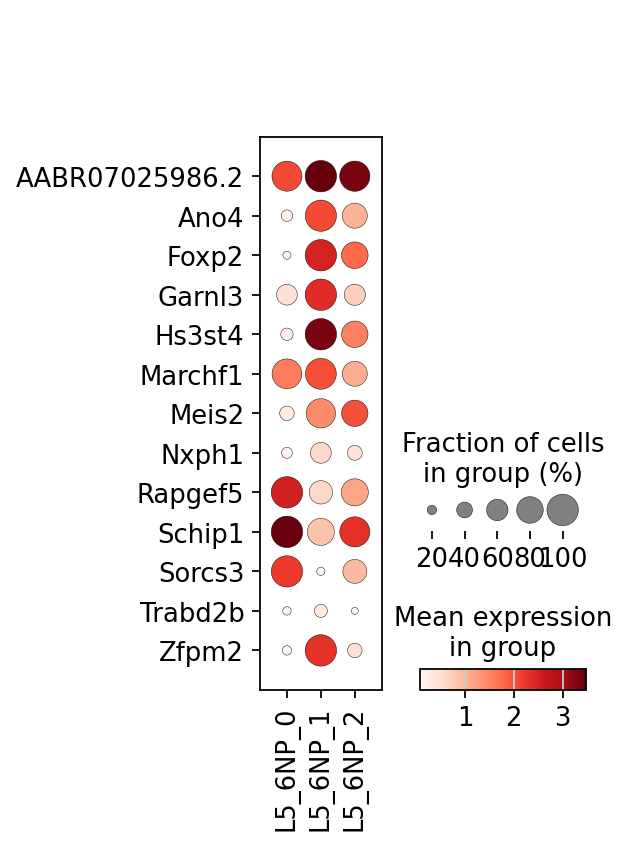

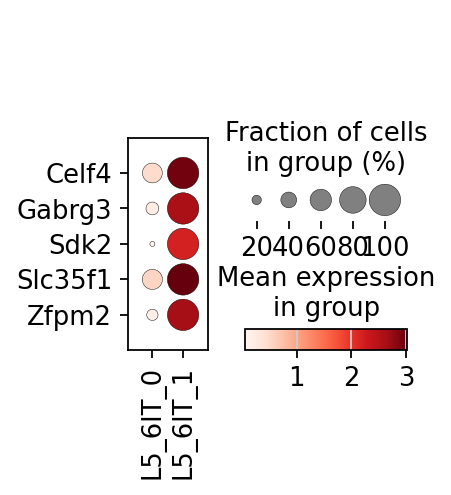

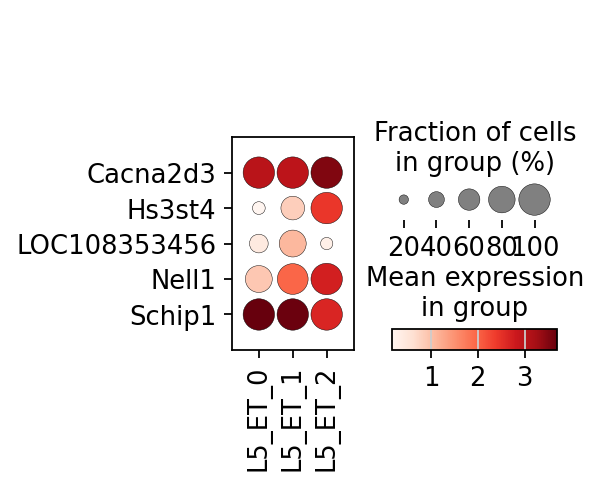

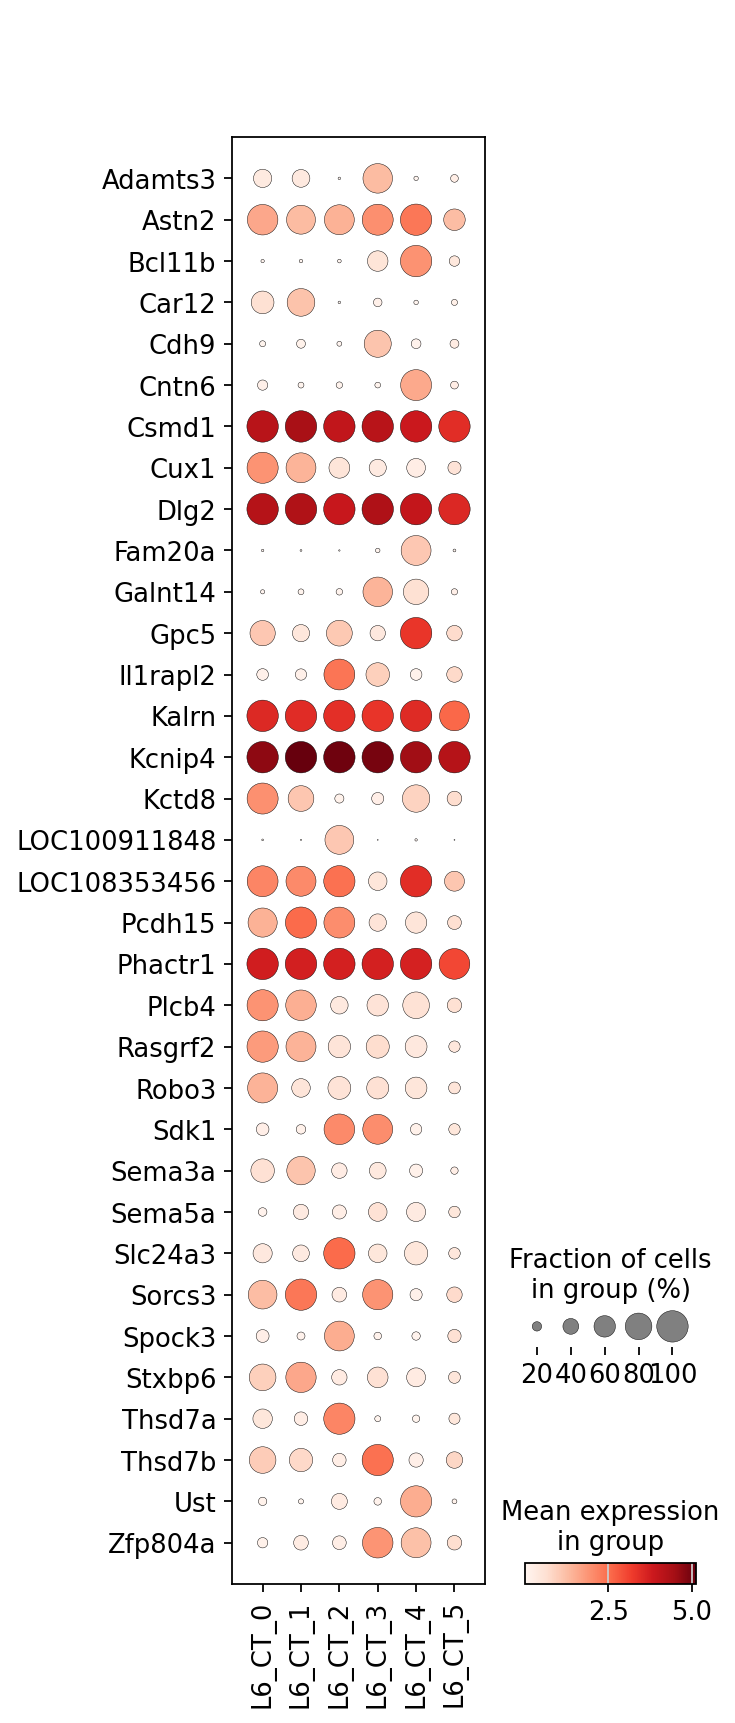

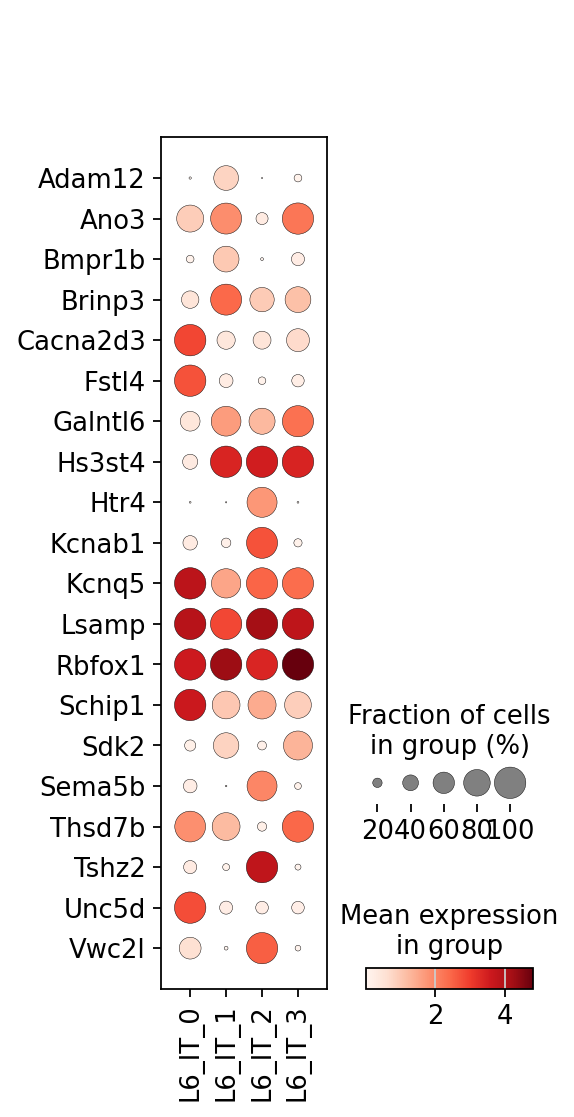

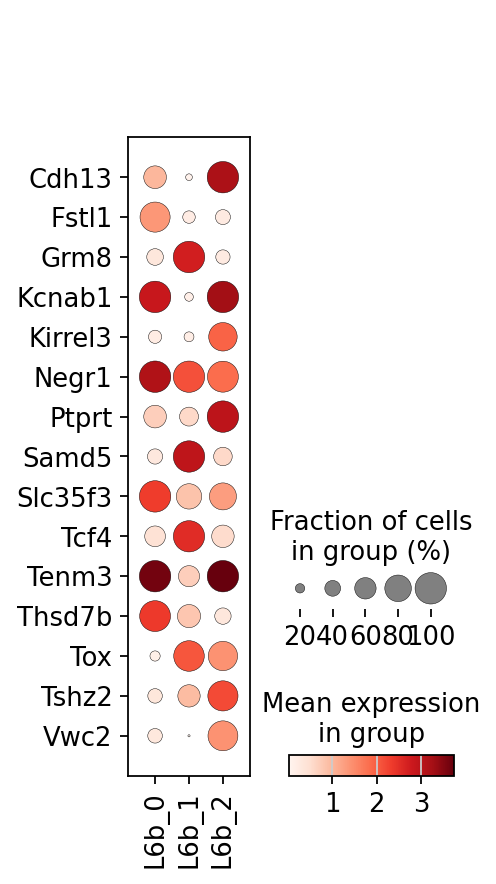

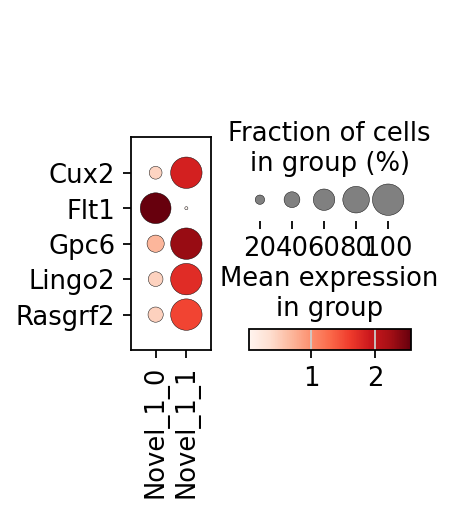

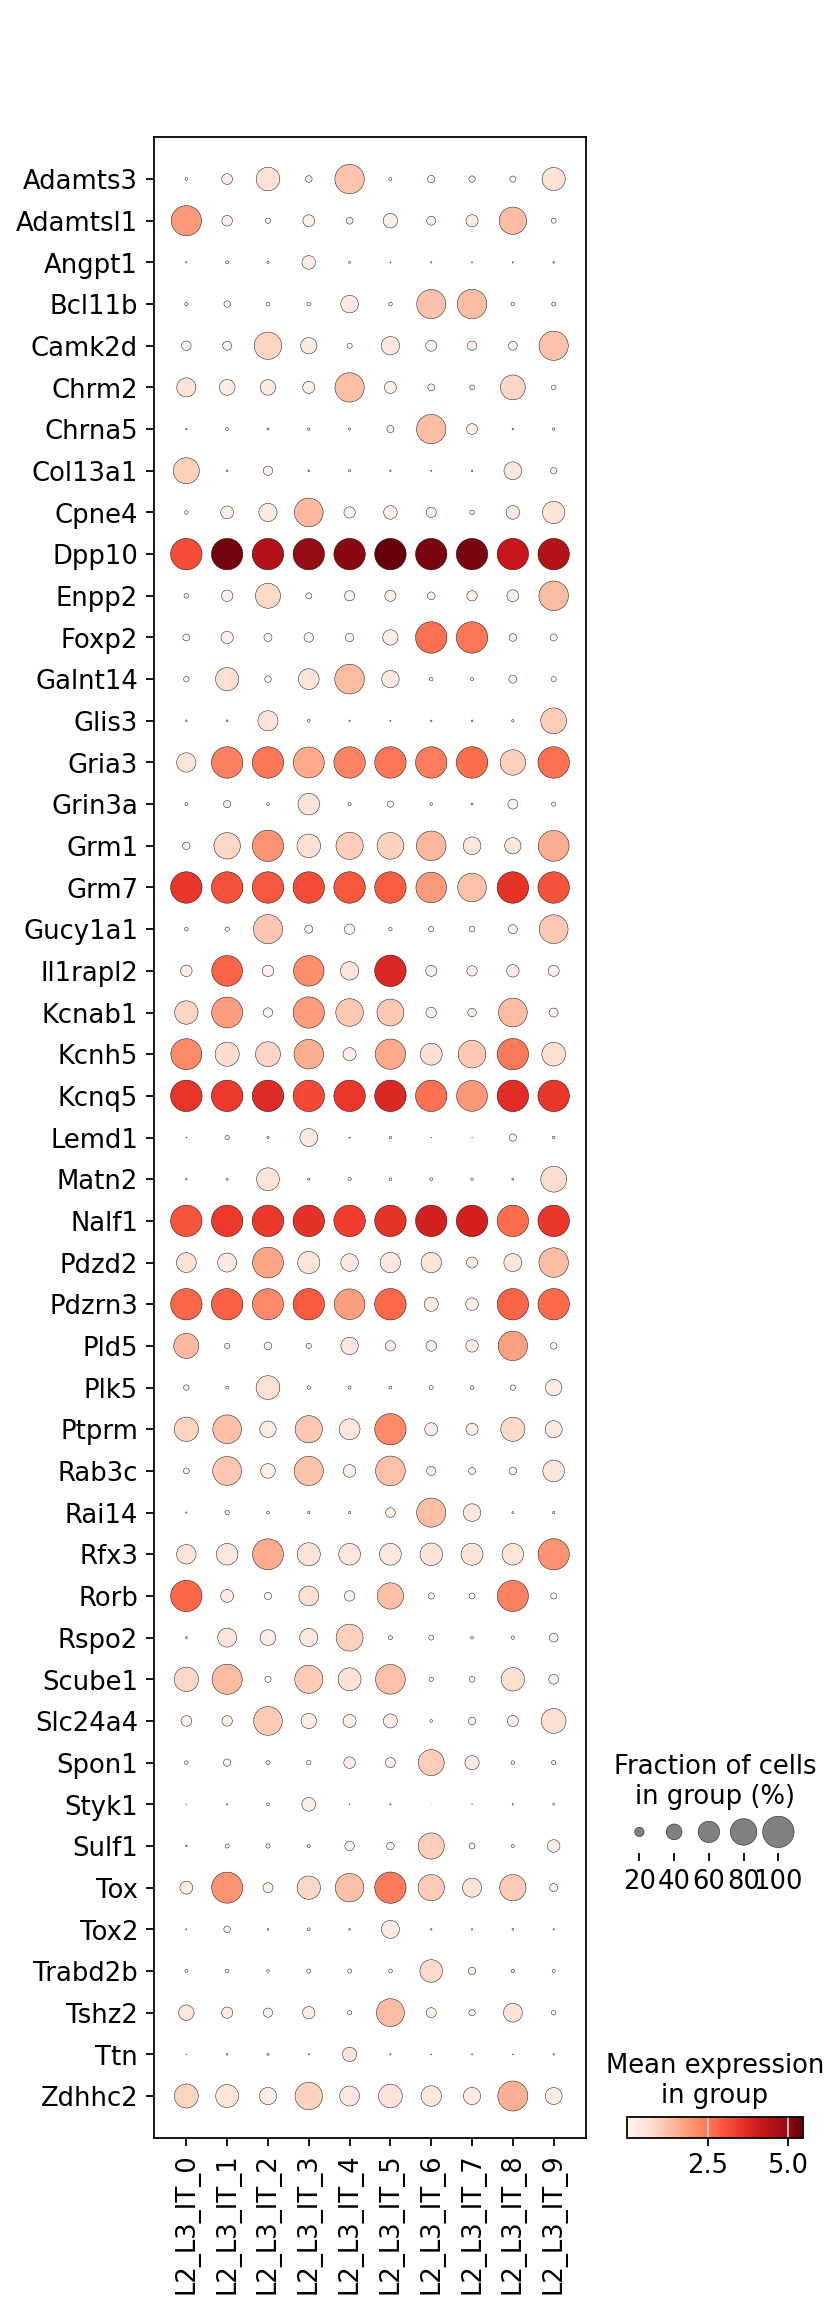

In [ ]:
#top 5 DE genes
subdir = "exc_subclass"
celldir = "exc_celltype_DE"

DE_genes = dict()
celltype_list = []

for file in os.listdir(os.path.join(input_DE_dir,subdir,"run2")):
  if file.endswith("_Cov.tsv") :
    celltype = file[0:file.find("limmatrend")-1]
    #print(celltype)
    celltype_list.append(celltype)
    DE_genes[celltype] = []


for file in os.listdir(os.path.join(input_DE_dir,celldir)):
  #find cell type top DE gene output txt file
  if file.endswith("Cov.tsv"):
    celltype = file[0:file.find("limmatrend")-1]#.split("_")
    #celltype = "_".join(celltype_name_list[0:len(celltype_name_list)])

    #print(celltype)
    #print(file)
    de_genes_df = pd.read_csv(os.path.join(input_DE_dir,celldir,file),sep="\t",header=0,index_col=0)
    de_genes_df.index.name = "gene"
    #print(de_genes_df.index[0:5])
    for key in DE_genes.keys():
      if celltype.startswith(key):
        DE_genes[key].append(de_genes_df.index[0:5])
    #DE_genes[celltype].extend(de_genes_df.gene)
#print(DE_genes.keys())
#print(DE_genes.values())
for key, value in DE_genes.items():
  #print(value)
  #print(key + ":" + str(len(value)))
  pd.DataFrame({'gene':np.unique(value)}).to_csv(os.path.join(input_DE_dir,celldir,key+"_DE_genes_top5.tsv"),sep="\t",index=False)

  if key != "L23_5IT" and key != "Novel_3" and key != "Novel_2" and key != "L5_IT" and key != "L6_IT_Cpa6":
    adata = sc.read_h5ad(os.path.join(input_DE_dir,"rat_exc_"+key+"_raw_filt_norm_subclass.h5ad"))
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    print(value)
    #sc.pl.dotplot(adata, var_names=DE_genes, groupby="subclass", categories_order=list(DE_genes.keys()), dendrogram=False, swap_axes=True)
    sc.pl.dotplot(adata, var_names=np.unique(value), groupby="cluster_label", dendrogram=False, swap_axes=True,show=False)
    plt.savefig(os.path.join(input_DE_dir,"rat_dotplot"+key+"_by_DE_top5_genes.png"))

In [ ]:
#subclass dotplot
adata_subclass = sc.read_h5ad(os.path.join(input_DE_dir,"rat_exc_cell_types_raw_filt_norm_subclass.h5ad"))
sc.pp.normalize_total(adata_subclass, target_sum=1e4)
sc.pp.log1p(adata_subclass)

In [ ]:
subdir = "exc_subclass"
DE_genes = dict()
celltype_list = []
for file in os.listdir(os.path.join(input_DE_dir,subdir, "run2")):
  if file.endswith("_Cov.tsv") :
    celltype = file[0:file.find("limmatrend")-1]
    print(celltype)
    celltype_list.append(celltype)
    DE_genes[celltype] = []

In [ ]:
for file in os.listdir(os.path.join(input_DE_dir,subdir,"run2","sigDE","adjPval05FC1.4")):
  #find cell type top DE gene output txt file
  if file.endswith("adjPval05_FC1.4.tsv"):
    cellclass = file[0:file.find("limma")-1]
    #celltype = "_".join(celltype_name_list[0:len(celltype_name_list)])

    #print(cellclass)
    #print(file)
    de_genes_df = pd.read_csv(os.path.join(input_DE_dir,subdir,"run2","sigDE","adjPval05FC1.4",file),sep="\t",header=0,index_col=0)
    de_genes_df.index.name = "gene"
    #print(de_genes_df.index[0:5])
    for key in DE_genes.keys():
      if key == cellclass:
        print(key)
        print(cellclass)
        DE_genes[key].extend(list(de_genes_df.index[0:5]))

/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


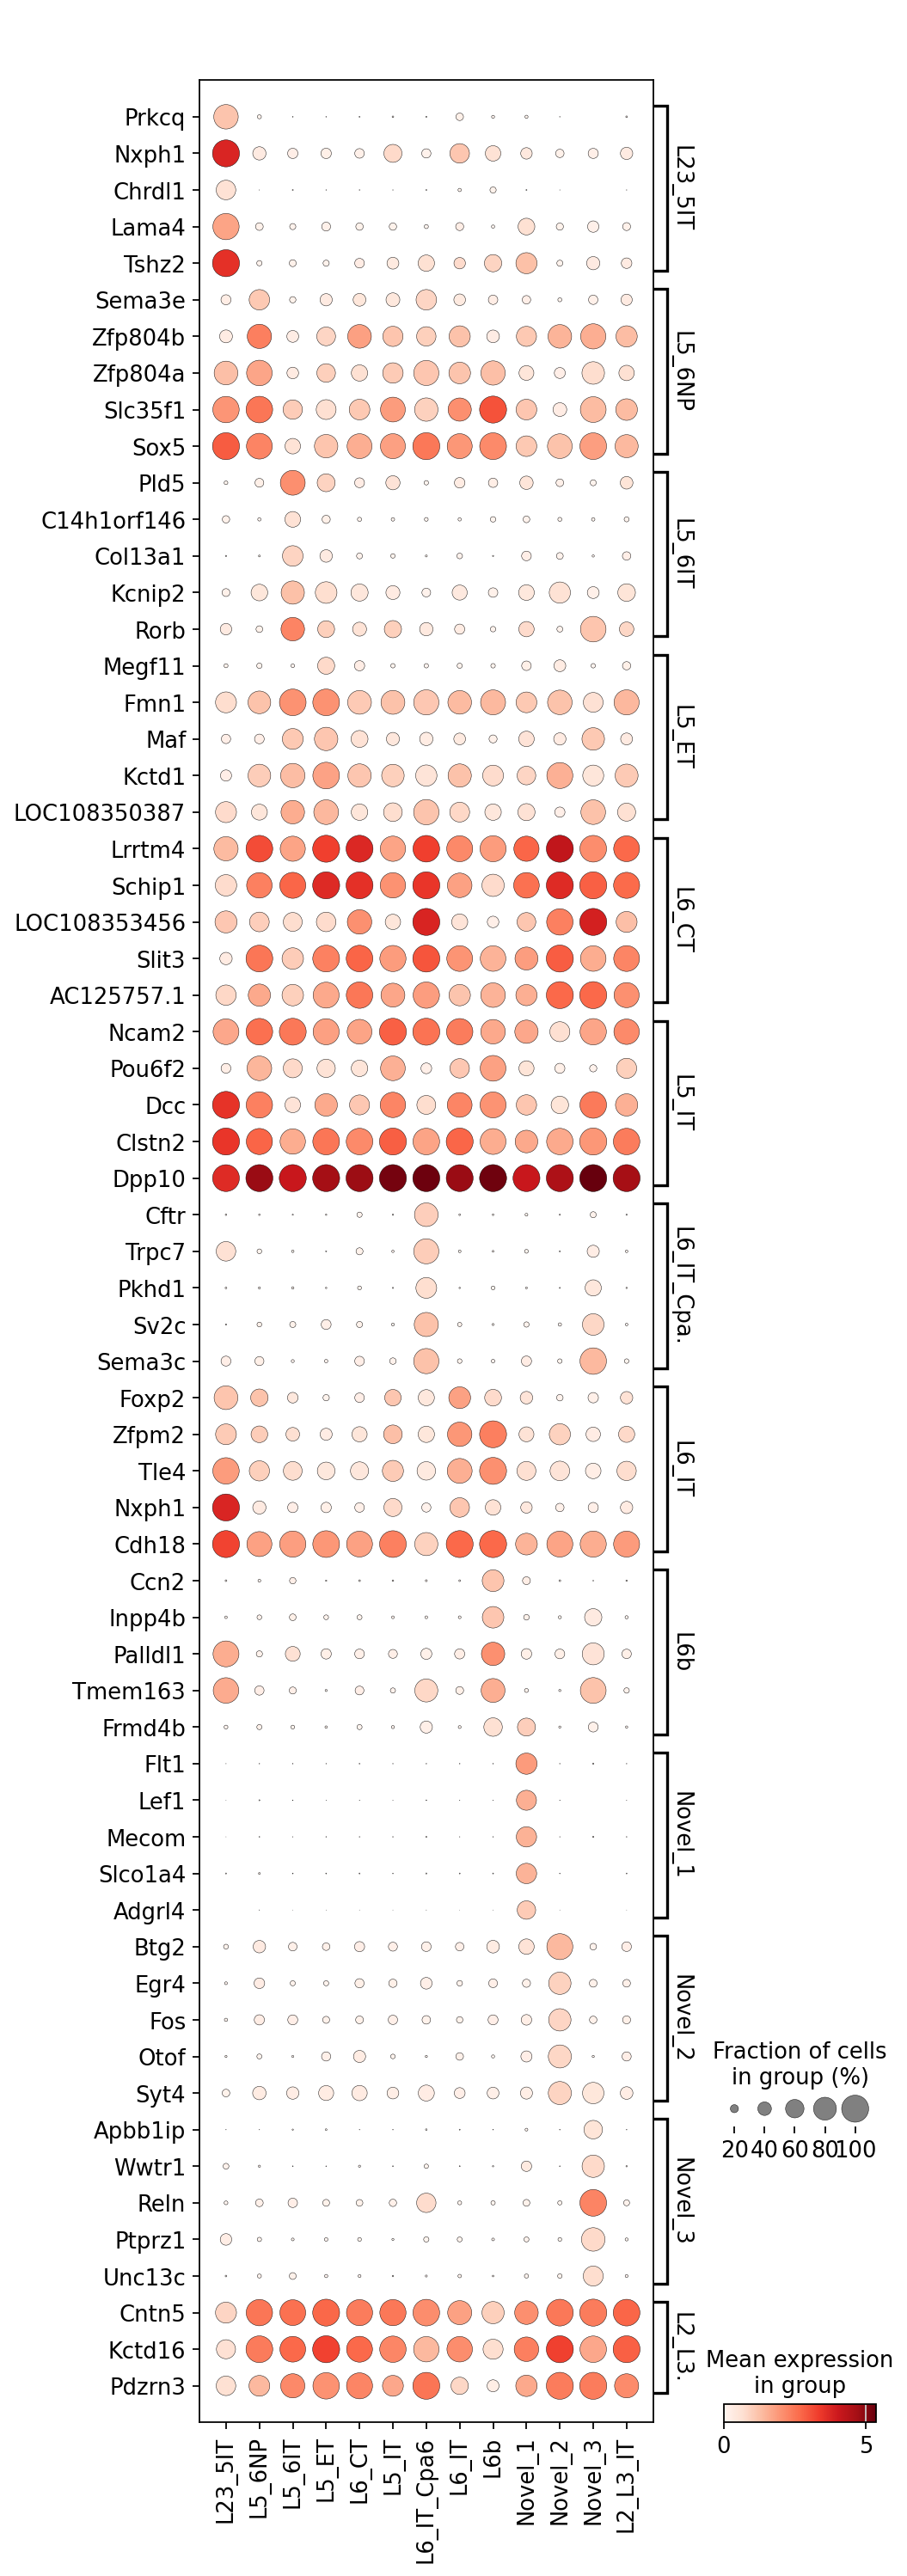

<Figure size 320x320 with 0 Axes>

In [ ]:
genelist = []
for key, value in DE_genes.items():
  #print(value)
  #print(key + ":" + str(len(value)))
  pd.DataFrame({'gene':np.unique(value)}).to_csv(os.path.join(input_DE_dir,subdir,key+"_DE_genes_top5.tsv"),sep="\t",index=False)
  genelist.extend(value)
  #pd.DataFrame({'gene':np.unique(value)}).to_csv(os.path.join(input_DE_dir,subdir,key+"_DE_genes_top5.tsv"),sep="\t",index=False)

  #adata = sc.read_h5ad(os.path.join(input_DE_dir,"rat_exc_"+key+"_raw_filt_norm_subclass.h5ad"))
  #sc.pp.normalize_total(adata, target_sum=1e4)
  #sc.pp.log1p(adata)
  #print(adata)

sc.pl.dotplot(adata_subclass, var_names=DE_genes, groupby="subclass", categories_order=list(DE_genes.keys()), dendrogram=False, swap_axes=True)
#sc.pl.dotplot(adata, var_names=np.unique(genelist), groupby="subclass", dendrogram=False, swap_axes=True,show=False)
plt.savefig(os.path.join(input_DE_dir,"rat_dotplot"+key+"_by_DE_top5_genes.png"))

In [ ]:
adata_celltype = sc.read_h5ad(os.path.join(input_DE_dir,"rat_exc_cell_types_raw_filt_norm_subclass.h5ad"))
sc.pp.normalize_total(adata_celltype, target_sum=1e4)
sc.pp.log1p(adata_celltype)

In [ ]:
subdir = "exc_celltype_DE"
DE_genes = dict()
celltype_list = []
for file in os.listdir(os.path.join(input_DE_dir,subdir)):
  if file.endswith("_top_gene_adjPval05_FC1.4.tsv"):
    celltype = file[0:file.find("limmatrend")-1]
    print(celltype)
    celltype_list.append(celltype)
    DE_genes[celltype] = []

In [ ]:
for file in os.listdir(os.path.join(input_DE_dir,subdir)):
  #find cell type top DE gene output txt file
  if file.endswith("gene_adjPval05_FC1.4.tsv"):
    cellclass = file[0:file.find("limma")-1]
    #celltype = "_".join(celltype_name_list[0:len(celltype_name_list)])

    #print(cellclass)
    #print(file)
    de_genes_df = pd.read_csv(os.path.join(input_DE_dir,subdir,file),sep="\t",header=0,index_col=0)
    de_genes_df.index.name = "gene"
    #print(de_genes_df.index[0:5])
    for key in DE_genes.keys():
      if key == cellclass:
        print(key)
        print(cellclass)
        DE_genes[key].extend(list(de_genes_df.index[0:5]))

In [ ]:
adata_celltype=adata_celltype[adata_celltype.obs["cluster_label"]!="L5_IT_0",:]
adata_celltype=adata_celltype[adata_celltype.obs["cluster_label"]!="L23_5IT_0",:]
adata_celltype=adata_celltype[adata_celltype.obs["cluster_label"]!="L5_IT_3",:]
adata_celltype=adata_celltype[adata_celltype.obs["cluster_label"]!="L5_ET_0",:]
adata_celltype=adata_celltype[adata_celltype.obs["cluster_label"]!="L5_IT_1",:]
adata_celltype=adata_celltype[adata_celltype.obs["cluster_label"]!="L5_IT_2",:]
adata_celltype=adata_celltype[adata_celltype.obs["cluster_label"]!="L5_ET_2",:]
adata_celltype=adata_celltype[adata_celltype.obs["cluster_label"]!="Novel_2_0",:]
adata_celltype=adata_celltype[adata_celltype.obs["cluster_label"]!="Novel_3_0",:]

/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


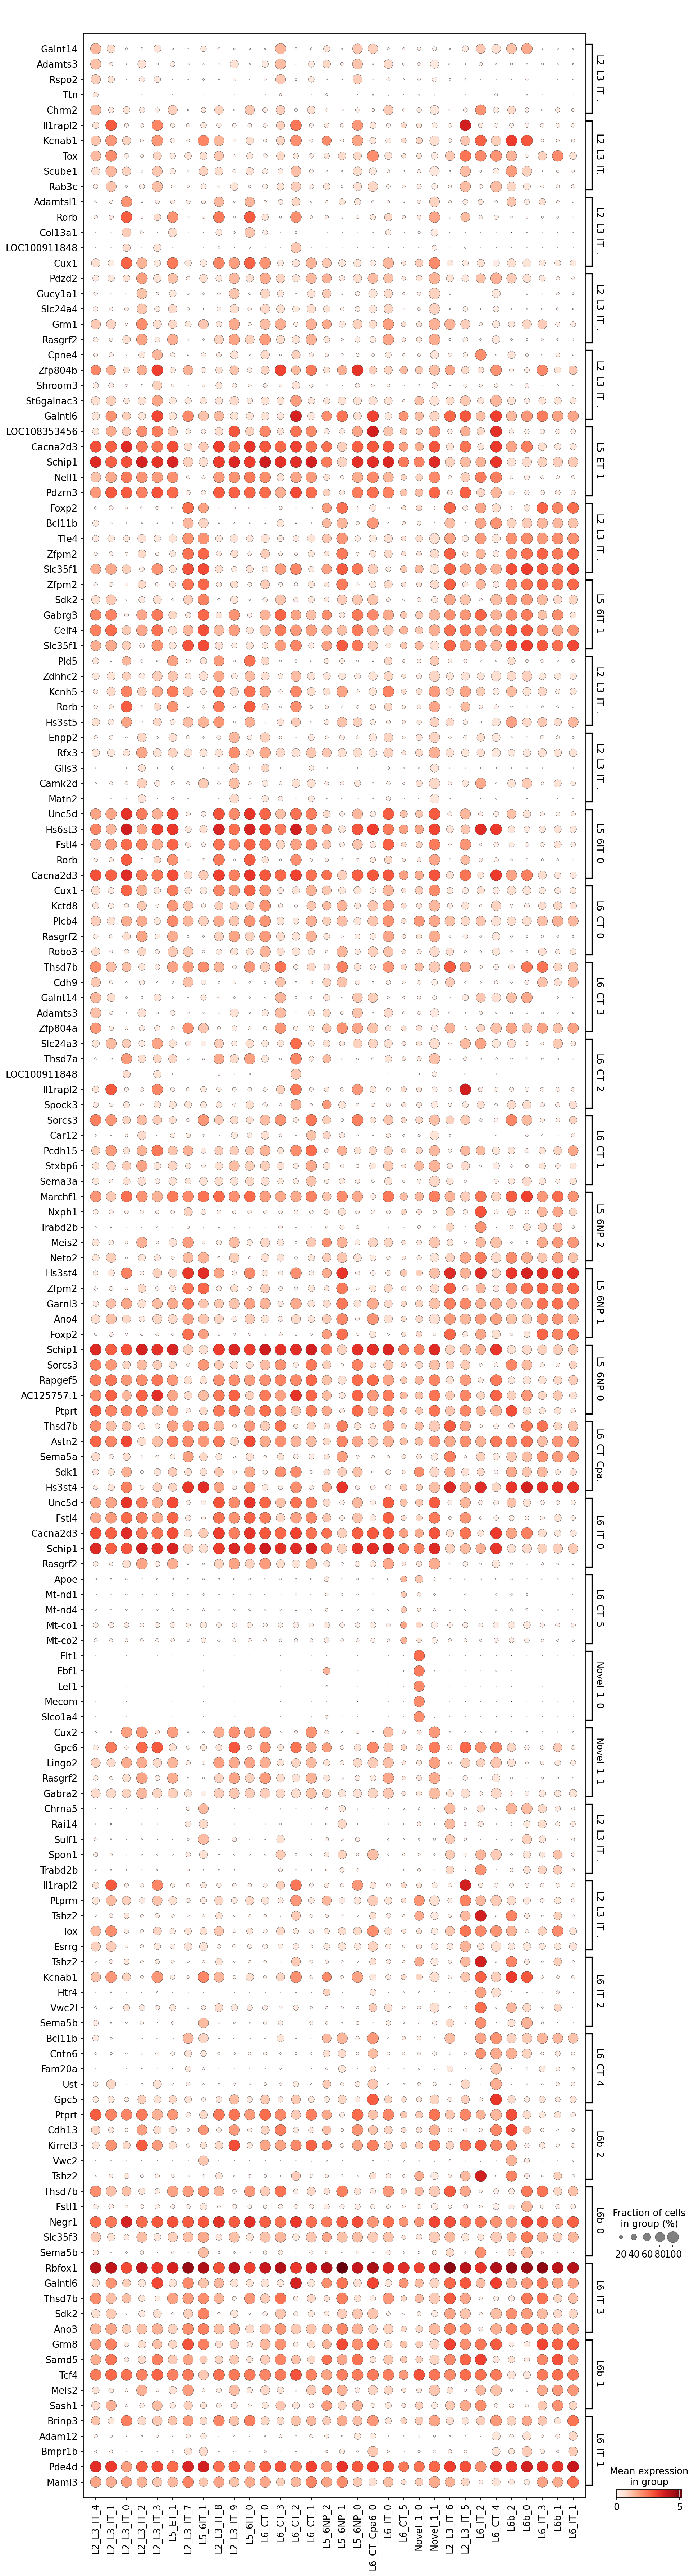

<Figure size 320x320 with 0 Axes>

In [ ]:
genelist = []
for key, value in DE_genes.items():
  #print(value)
  #print(key + ":" + str(len(value)))
  pd.DataFrame({'gene':np.unique(value)}).to_csv(os.path.join(input_DE_dir,subdir,key+"_DE_genes_top5.tsv"),sep="\t",index=False)
  genelist.extend(value)
  #pd.DataFrame({'gene':np.unique(value)}).to_csv(os.path.join(input_DE_dir,subdir,key+"_DE_genes_top5.tsv"),sep="\t",index=False)

  #adata = sc.read_h5ad(os.path.join(input_DE_dir,"rat_exc_"+key+"_raw_filt_norm_subclass.h5ad"))
  #sc.pp.normalize_total(adata, target_sum=1e4)
  #sc.pp.log1p(adata)
  #print(adata)

sc.pl.dotplot(adata_celltype, var_names=DE_genes, groupby="cluster_label", categories_order=list(DE_genes.keys()), dendrogram=False, swap_axes=True)
#sc.pl.dotplot(adata, var_names=np.unique(genelist), groupby="subclass", dendrogram=False, swap_axes=True,show=False)
plt.savefig(os.path.join(input_DE_dir,"rat_dotplot_cellclass"+key+"_by_DE_top5_genes.png"))